In [25]:
import os
import sys
from pathlib import Path

import librosa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from src.utils.eeg_spectrogram_creator import EEGSpectrogramGenerator

plt.rcParams['font.size'] = 12          # Base font size
plt.rcParams['axes.titlesize'] = 18     # Axes title
plt.rcParams['axes.labelsize'] = 16     # X and Y labels
plt.rcParams['xtick.labelsize'] = 14    # X tick labels
plt.rcParams['ytick.labelsize'] = 14    # Y tick labels
plt.rcParams['legend.fontsize'] = 14    # Legend
plt.rcParams['figure.titlesize'] = 30   # Figure title (suptitle)

In [26]:
EEG_INDEX = 1000

TRAIN_CSV = Path(os.getcwd()).parent.parent / "data" / "train.csv"
EEG_DIR = Path(os.getcwd()).parent.parent / "data" / "train_eegs"
KAGGLE_SPECTROGRAM_DIR = Path(os.getcwd()).parent.parent / "data" / "train_spectrograms"

In [27]:
train_df = pd.read_csv(TRAIN_CSV)

row = train_df.iloc[EEG_INDEX]
eeg_id = row["eeg_id"]
spectrogram_id = row["spectrogram_id"]

eeg_parquet_path = EEG_DIR / f"{eeg_id}.parquet"
kaggle_spectrogram_path = KAGGLE_SPECTROGRAM_DIR / f"{spectrogram_id}.parquet"

print(f"EEG ID: {eeg_id}")
print(f"Label: {row['expert_consensus']}")

EEG ID: 3088095149
Label: GPD


In [28]:
print(row)

eeg_id                              3088095149
eeg_sub_id                                  10
eeg_label_offset_seconds                  52.0
spectrogram_id                        13143748
spectrogram_sub_id                          46
spectrogram_label_offset_seconds        1606.0
label_id                             469510122
patient_id                               34998
expert_consensus                           GPD
seizure_vote                                 0
lpd_vote                                     2
gpd_vote                                     6
lrda_vote                                    1
grda_vote                                    4
other_vote                                   2
Name: 1000, dtype: object


In [29]:
eeg_offset = row["eeg_label_offset_seconds"]
eeg_parquet = pd.read_parquet(eeg_parquet_path)
eeg_parquet = eeg_parquet.drop(columns=["EKG"])
eeg_parquet = eeg_parquet.iloc[int(eeg_offset * 200) : int(eeg_offset * 200 + 200 * 50)] # select 50 seconds of data

kaggle_spectrogram_offset = row["spectrogram_label_offset_seconds"]
kaggle_spectrogram_content = pd.read_parquet(kaggle_spectrogram_path)
kaggle_spectrogram_content = kaggle_spectrogram_content.drop(columns=["time"])
kaggle_spectrogram_content = kaggle_spectrogram_content.iloc[int(kaggle_spectrogram_offset // 2) : int(kaggle_spectrogram_offset // 2 + 600 / 2)] # select 600 seconds of data

In [30]:
spect_generator = EEGSpectrogramGenerator(["stft", "mel", "cwt"])

spects = spect_generator.generate(eeg_parquet)

stft_eeg_spectrogram_parquet = spects["stft"]
mel_eeg_spectrogram_parquet = spects["mel"]
cwt_eeg_spectrogram_parquet = spects["cwt"]

In [31]:
print(f"EEG length: {eeg_parquet.shape[0] / 200} seconds")
print(f"Kaggle spectrogram length: {kaggle_spectrogram_content.shape[0] * 2} seconds")

EEG length: 50.0 seconds
Kaggle spectrogram length: 600 seconds


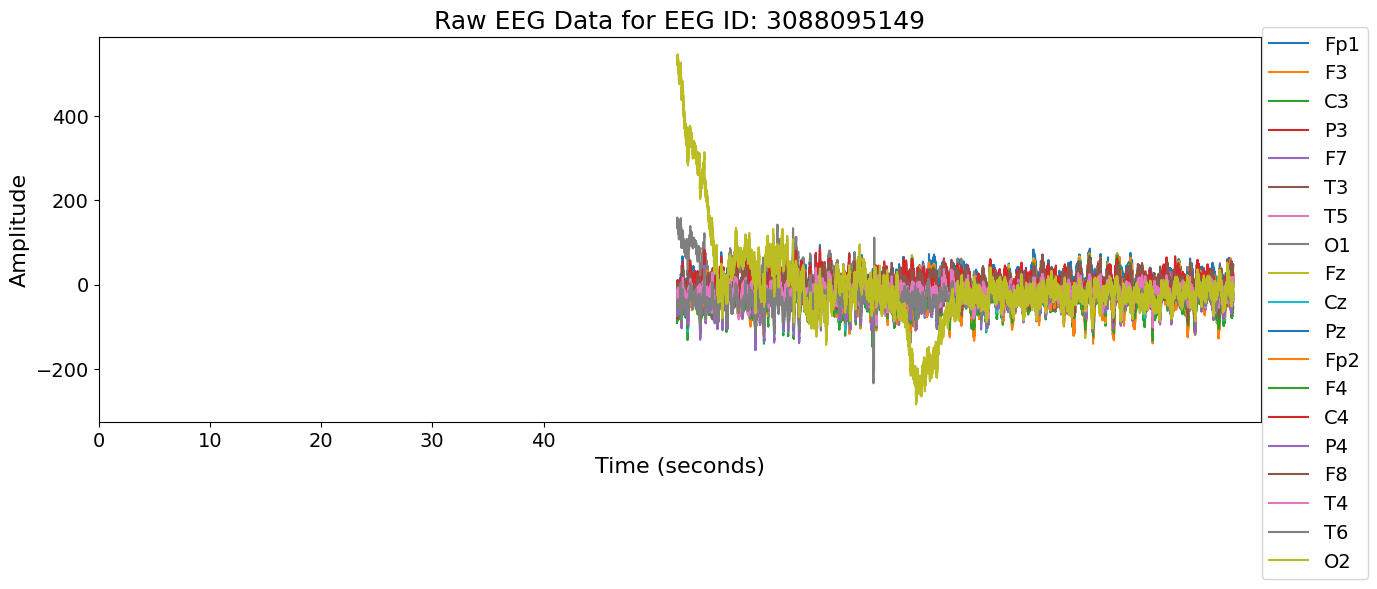

In [32]:
# visualize the raw EEG data in one line plot
# divide x-axis by 200 to convert from samples to seconds

fig, ax = plt.subplots(figsize=(15, 5))
for channel in eeg_parquet.columns:
    ax.plot(eeg_parquet[channel], label=channel)

ax.set_title(f"Raw EEG Data for EEG ID: {eeg_id}")
ax.set_xticks(ticks=np.arange(0, len(eeg_parquet), 2000), labels=np.arange(0, len(eeg_parquet) // 200, 10))
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Amplitude")
ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.05));

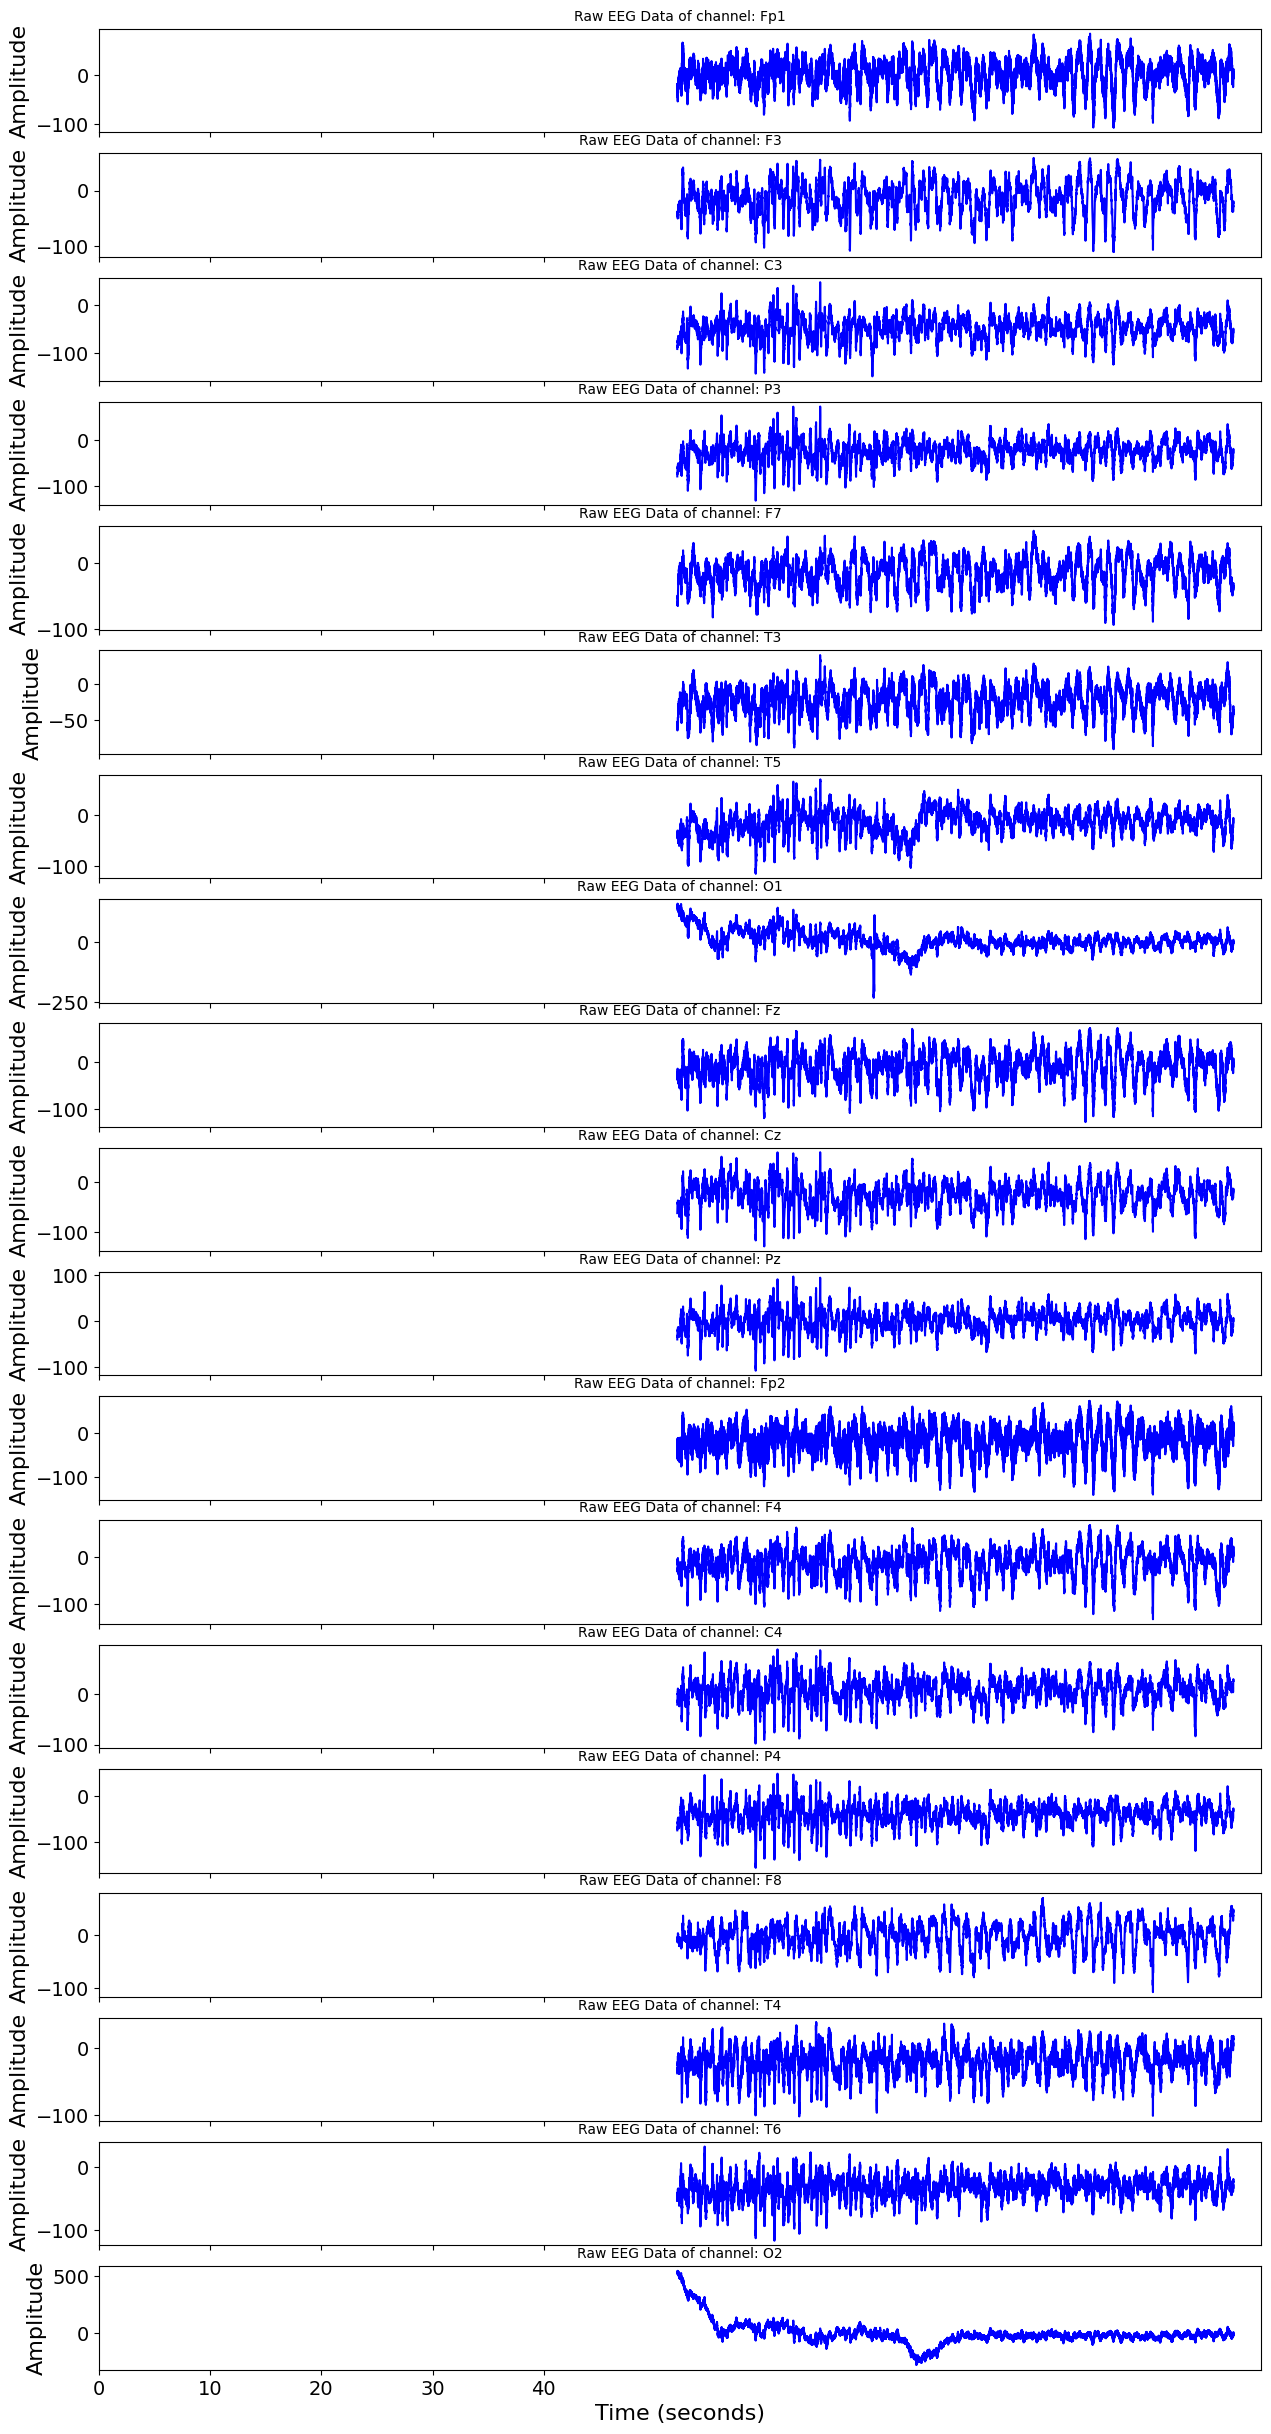

In [33]:
# visualize the raw EEG data in one line plot per channel
fig, axs = plt.subplots(nrows=len(eeg_parquet.columns), ncols=1, figsize=(15, 1.6 * len(eeg_parquet.columns)), sharex=True)
for i, channel in enumerate(eeg_parquet.columns):
    axs[i].plot(eeg_parquet[channel], label=channel, color='blue')
    axs[i].set_title(f"Raw EEG Data of channel: {channel}", fontsize=10)
    axs[i].set_ylabel("Amplitude")

axs[-1].set_xticks(ticks=np.arange(0, len(eeg_parquet), 2000), labels=np.arange(0, len(eeg_parquet) // 200, 10))
axs[-1].set_xlabel("Time (seconds)");

In [34]:
def clean_kaggle_spectrogram(data):
    data = librosa.amplitude_to_db(data, ref=np.max) 
    data = spect_generator._normalize_spectrogram(data)
    return data

min: -1.0, max: 1.0
min: -1.0, max: 1.0
min: -1.0, max: 1.0
min: -1.0, max: 1.0


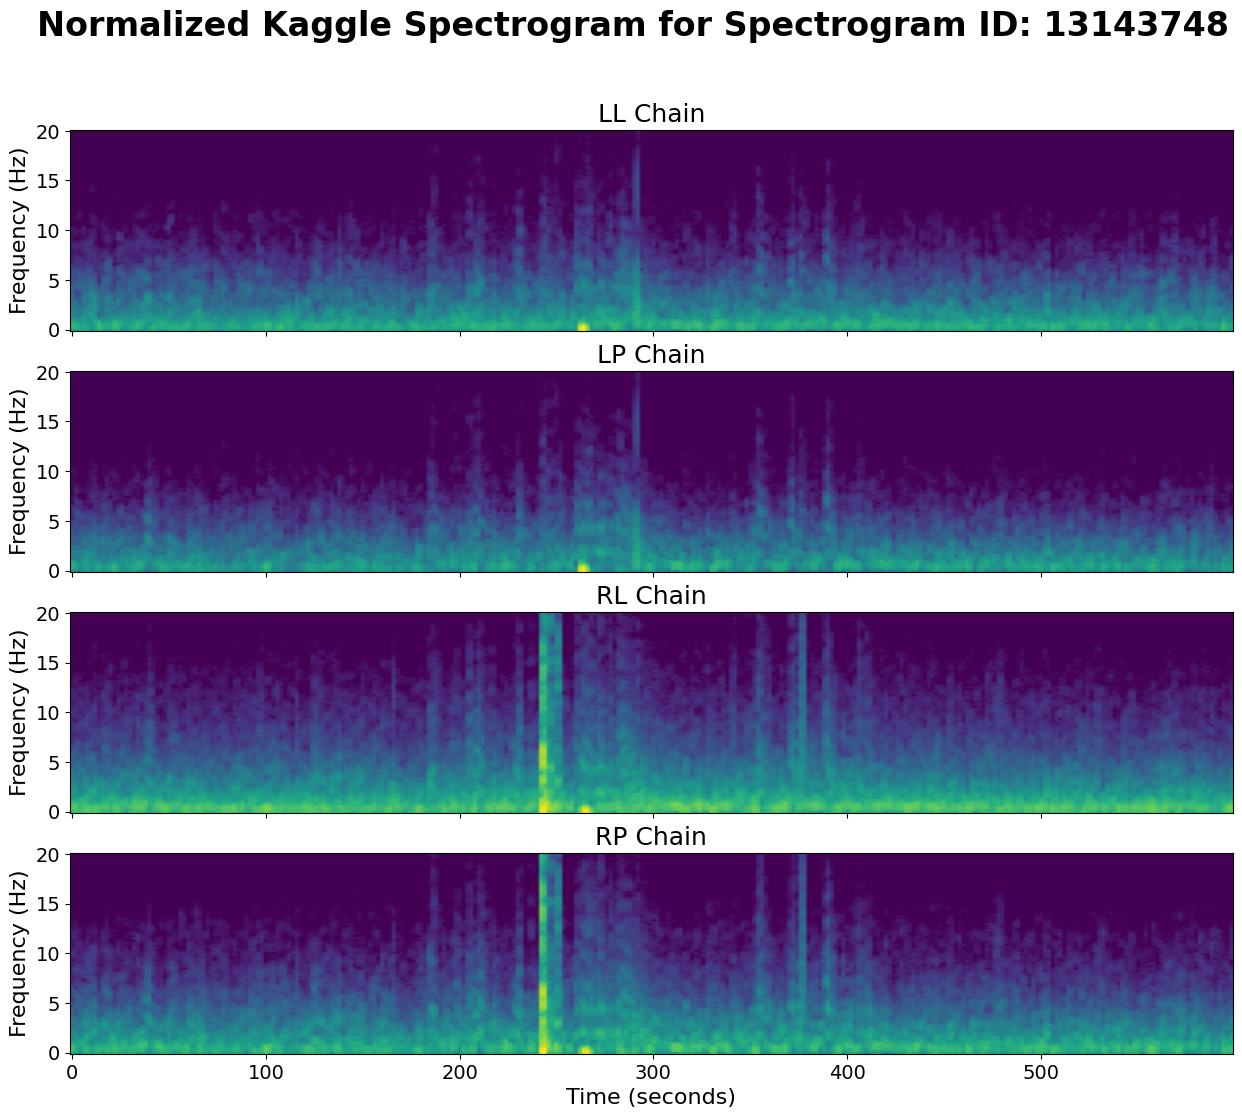

In [35]:
# visualize the Kaggle spectrogram
chain_names = ["LL", "LP", "RL", "RP"]

fig, axs = plt.subplots(nrows=len(chain_names), ncols=1, figsize=(15, 3 * len(chain_names)), sharex=True)
for i, chain in enumerate(chain_names):
    spectrogram_data = kaggle_spectrogram_content.filter(like=chain).to_numpy().T
    spectrogram_data = clean_kaggle_spectrogram(spectrogram_data)
    print(f"min: {spectrogram_data.min()}, max: {spectrogram_data.max()}")
    axs[i].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
    axs[i].set_title(f"{chain} Chain")
    axs[i].set_ylabel("Frequency (Hz)")
    axs[i].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 5), labels=np.linspace(0, 20, 5).astype(int))

axs[-1].set_xticks(ticks=np.arange(0, spectrogram_data.shape[1], 50), labels=np.arange(0, spectrogram_data.shape[1] * 2, 100))
axs[-1].set_xlabel("Time (seconds)");

fig.suptitle(f"Normalized Kaggle Spectrogram for Spectrogram ID: {spectrogram_id}", fontsize=24, fontweight='bold');

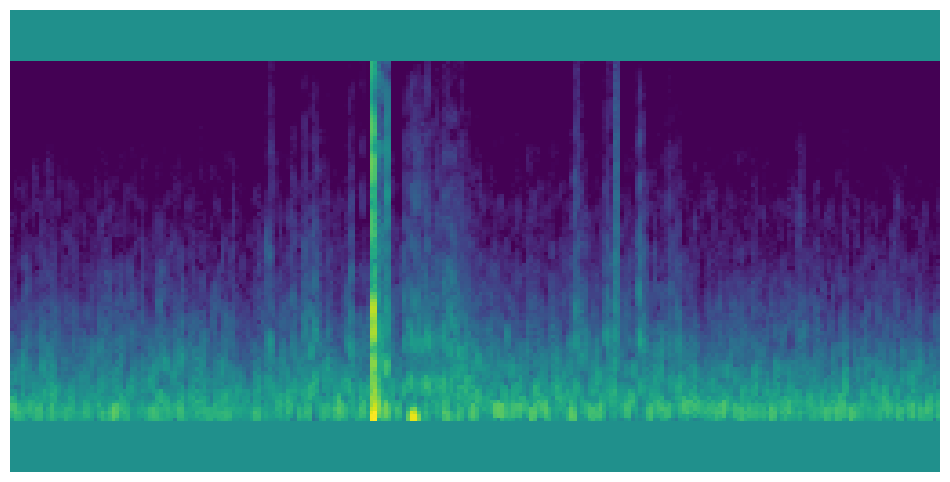

In [36]:
# visualize the Kaggle spectrogram
chain_name = "RL"

fig, ax = plt.subplots(figsize=(256 // 20, 128 // 20))
# spectrogram_data = cwt_eeg_spectrogram_parquet[:,:,4]
spectrogram_data = np.pad(spectrogram_data, ((14, 14), (0, 0)), mode='constant', constant_values=0)
# center crop to width 256
spectrogram_data = spectrogram_data[:, (spectrogram_data.shape[1] - 256) // 2 : (spectrogram_data.shape[1] + 256) // 2]
ax.imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
ax.set_axis_off()


min: -0.554282546043396, max: 1.0, avg: 0.14195458590984344
min: -0.5489177703857422, max: 1.0, avg: 0.20086346566677094
min: -0.781651496887207, max: 1.0, avg: -0.10663158446550369
min: -0.7668542861938477, max: 1.0, avg: -0.014469864778220654


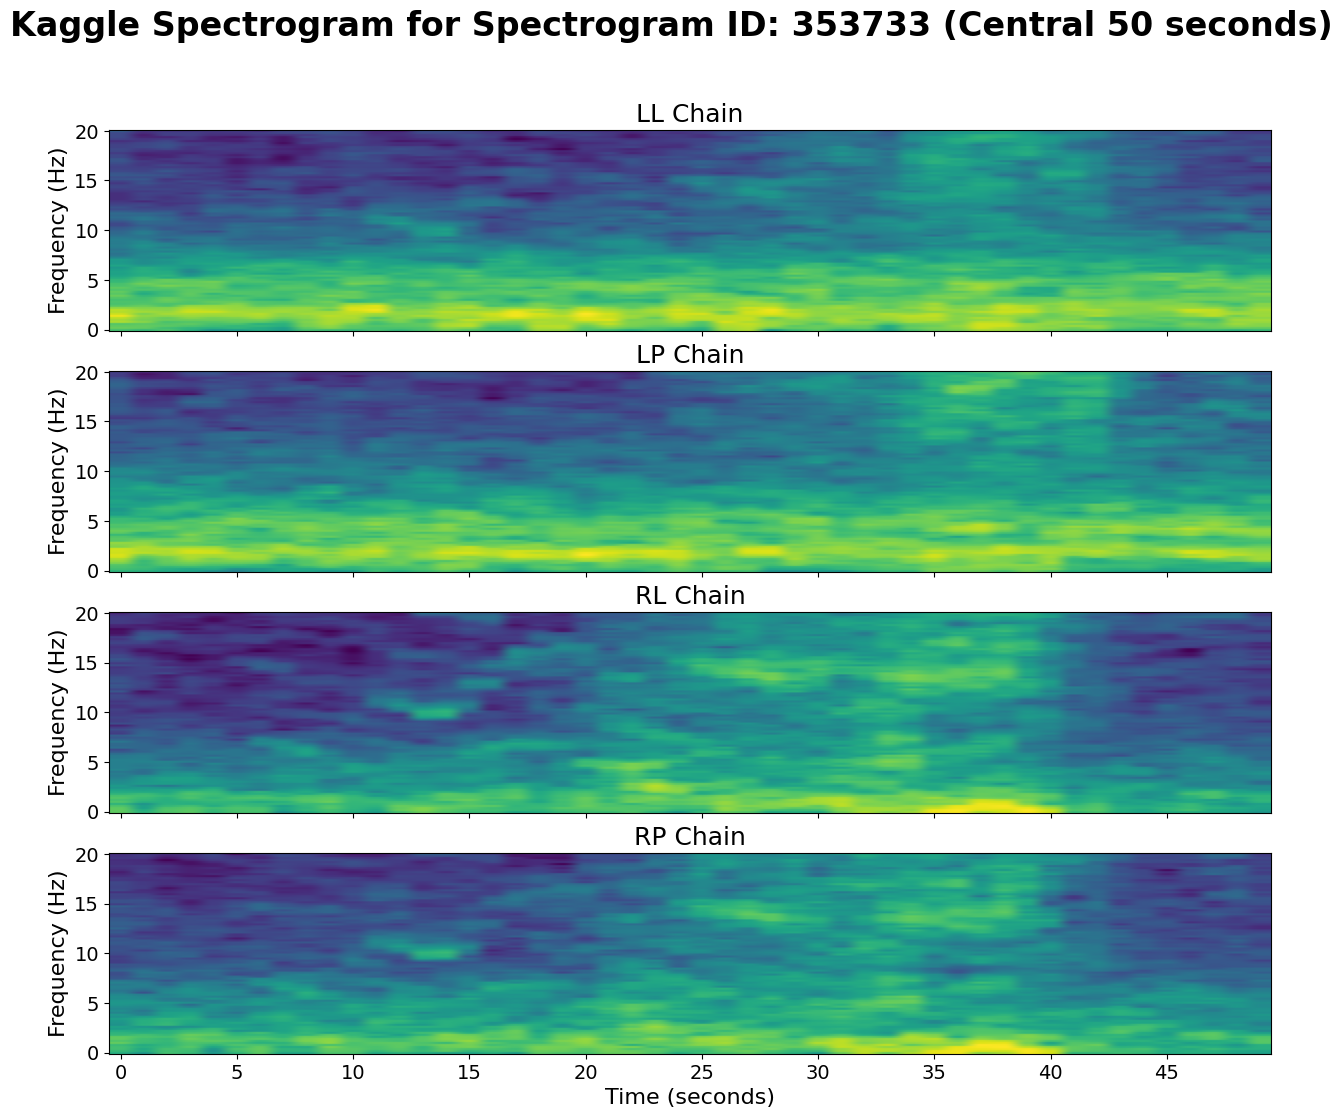

In [29]:
# visualize central 50 second of the Kaggle spectrogram
chain_names = ["LL", "LP", "RL", "RP"]
fig, axs = plt.subplots(nrows=len(chain_names), ncols=1, figsize=(15, 3 * len(chain_names)), sharex=True)
for i, chain in enumerate(chain_names):
    spectrogram_data = kaggle_spectrogram_content.filter(like=chain).to_numpy().T
    spectrogram_data = clean_kaggle_spectrogram(spectrogram_data)
    print(f"min: {spectrogram_data.min()}, max: {spectrogram_data.max()}, avg: {spectrogram_data.mean()}")
    center_start = spectrogram_data.shape[1] // 2 - 25
    center_end = spectrogram_data.shape[1] // 2 + 25
    axs[i].imshow(spectrogram_data[:, center_start:center_end], aspect='auto', origin='lower', cmap='viridis')
    axs[i].set_title(f"{chain} Chain")
    axs[i].set_ylabel("Frequency (Hz)")
    axs[i].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 5), labels=np.linspace(0, 20, 5).astype(int))

axs[-1].set_xticks(ticks=np.arange(0, 50, 5), labels=np.arange(0, 50, 5))
axs[-1].set_xlabel("Time (seconds)");
fig.suptitle(f"Kaggle Spectrogram for Spectrogram ID: {spectrogram_id} (Central 50 seconds)", fontsize=24, fontweight='bold');

min: -0.44614651799201965, max: 0.8826918601989746, avg : 0.12591581046581268
min: -0.5128122568130493, max: 0.9000358581542969, avg : 0.22977152466773987
min: -0.386272668838501, max: 0.9426539540290833, avg : 0.21899165213108063
min: -0.48352330923080444, max: 0.9534870982170105, avg : 0.08917457610368729
min: -0.8274463415145874, max: 0.9924436211585999, avg : -0.0491291806101799


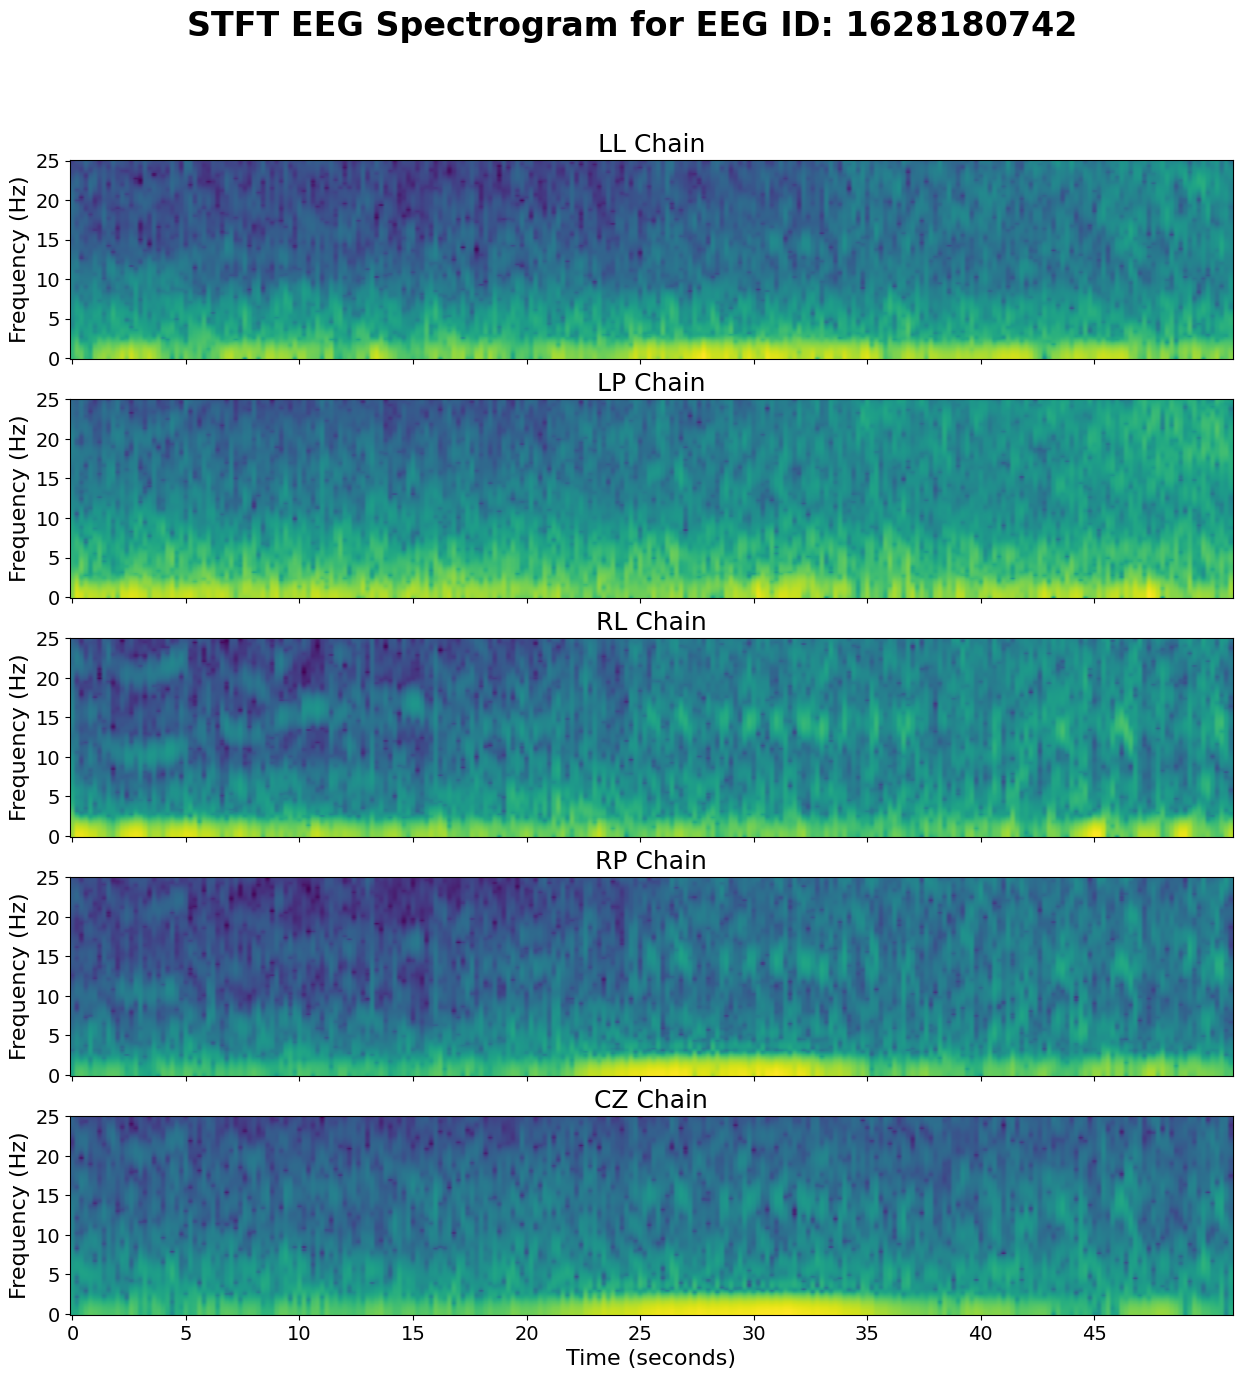

In [30]:
# visualize the EEG spectrogram
chain_names = ["LL", "LP", "RL", "RP", "CZ"]
fig, axs = plt.subplots(nrows=len(chain_names), ncols=1, figsize=(15, 3 * len(chain_names)), sharex=True)
for i, chain in enumerate(chain_names):
    spectrogram_data = stft_eeg_spectrogram_parquet[:, :, i]
    print(f"min: {spectrogram_data.min()}, max: {spectrogram_data.max()}, avg : {spectrogram_data.mean()}")
    axs[i].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
    axs[i].set_title(f"{chain} Chain")
    axs[i].set_ylabel("Frequency (Hz)")
    axs[i].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 6), labels=np.linspace(0, 25, 6).astype(int))

# 256 time steps for 50 seconds
axs[-1].set_xticks(ticks=np.arange(0, spectrogram_data.shape[1] - 25, 25), labels=np.arange(0, spectrogram_data.shape[1] * (50 / spectrogram_data.shape[1]), 5).astype(int))
axs[-1].set_xlabel("Time (seconds)")

fig.suptitle(f"STFT EEG Spectrogram for EEG ID: {eeg_id}", fontsize=24, fontweight='bold');

min: -0.4351634979248047, max: 0.8828913569450378
min: -0.5110200643539429, max: 0.9002388715744019
min: -0.37577497959136963, max: 0.9425873756408691
min: -0.4802471399307251, max: 0.9532885551452637
min: -0.8249396085739136, max: 0.9924081563949585


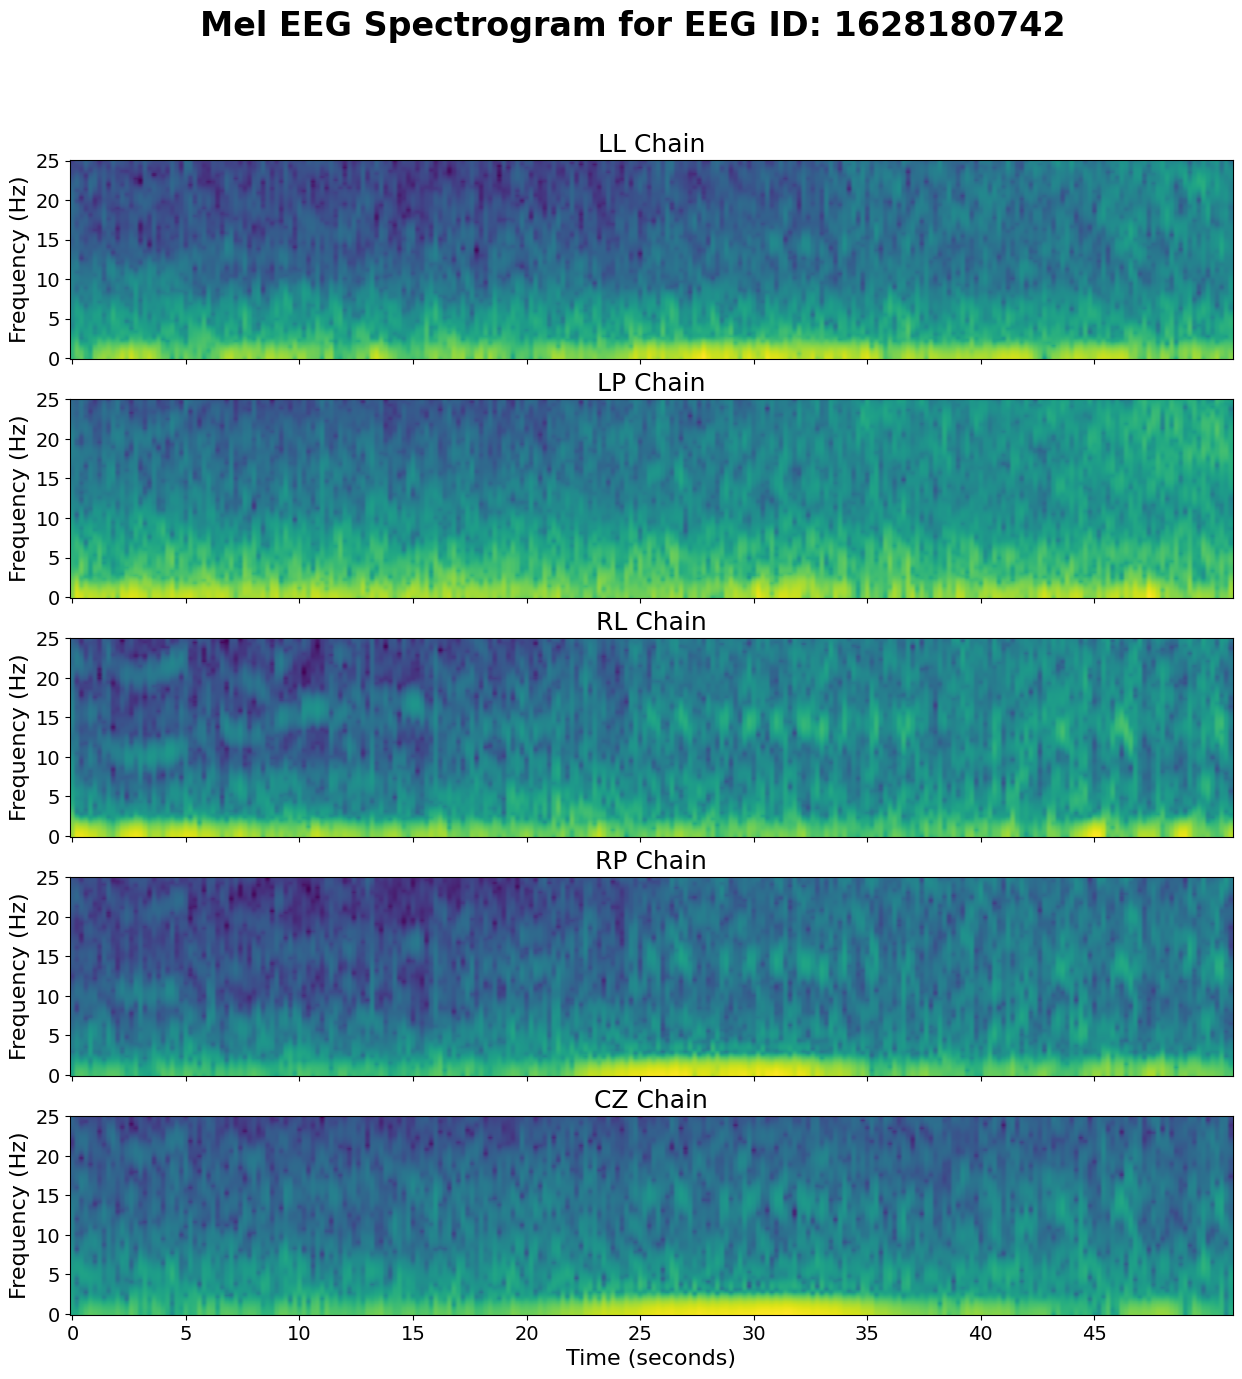

In [31]:
# visualize the EEG spectrogram
chain_names = ["LL", "LP", "RL", "RP", "CZ"]
fig, axs = plt.subplots(nrows=len(chain_names), ncols=1, figsize=(15, 3 * len(chain_names)), sharex=True)
for i, chain in enumerate(chain_names):
    spectrogram_data = mel_eeg_spectrogram_parquet[:, :, i]
    print(f"min: {spectrogram_data.min()}, max: {spectrogram_data.max()}")
    axs[i].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
    axs[i].set_title(f"{chain} Chain")
    axs[i].set_ylabel("Frequency (Hz)")
    axs[i].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 6), labels=np.linspace(0, 25, 6).astype(int))

# 256 time steps for 50 seconds
axs[-1].set_xticks(ticks=np.arange(0, spectrogram_data.shape[1] - 25, 25), labels=np.arange(0, spectrogram_data.shape[1] * (50 / spectrogram_data.shape[1]), 5).astype(int))
axs[-1].set_xlabel("Time (seconds)")

fig.suptitle(f"Mel EEG Spectrogram for EEG ID: {eeg_id}", fontsize=24, fontweight='bold');

min: -0.42401739954948425, max: 0.8950616717338562
min: -0.35477590560913086, max: 0.913536548614502
min: -0.4080342650413513, max: 0.9094246625900269
min: -0.3874024748802185, max: 0.9910944700241089
min: -0.6054671406745911, max: 0.9542135000228882


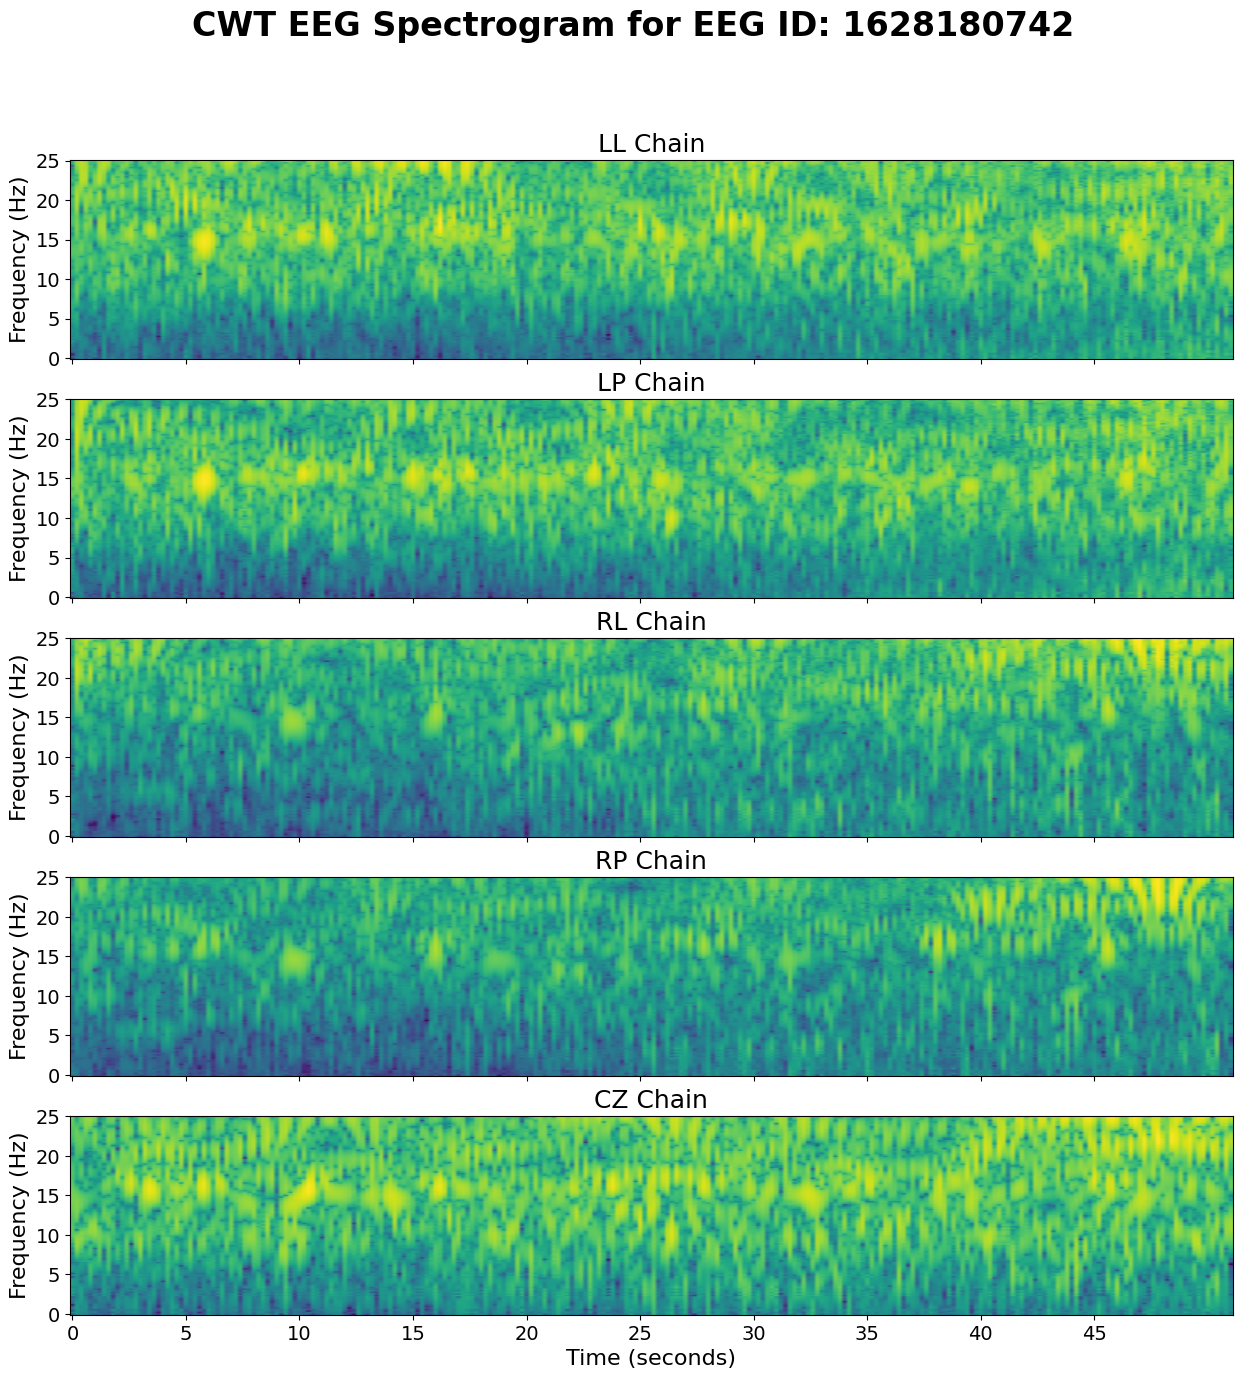

In [32]:
# visualize the EEG spectrogram
chain_names = ["LL", "LP", "RL", "RP", "CZ"]
fig, axs = plt.subplots(nrows=len(chain_names), ncols=1, figsize=(15, 3 * len(chain_names)), sharex=True)
for i, chain in enumerate(chain_names):
    spectrogram_data = cwt_eeg_spectrogram_parquet[:, :, i]
    print(f"min: {spectrogram_data.min()}, max: {spectrogram_data.max()}")
    axs[i].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
    axs[i].set_title(f"{chain} Chain")
    axs[i].set_ylabel("Frequency (Hz)")
    axs[i].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 6), labels=np.linspace(0, 25, 6).astype(int))

# 256 time steps for 50 seconds
axs[-1].set_xticks(ticks=np.arange(0, spectrogram_data.shape[1] - 25, 25), labels=np.arange(0, spectrogram_data.shape[1] * (50 / spectrogram_data.shape[1]), 5).astype(int))
axs[-1].set_xlabel("Time (seconds)")

fig.suptitle(f"CWT EEG Spectrogram for EEG ID: {eeg_id}", fontsize=24, fontweight='bold');

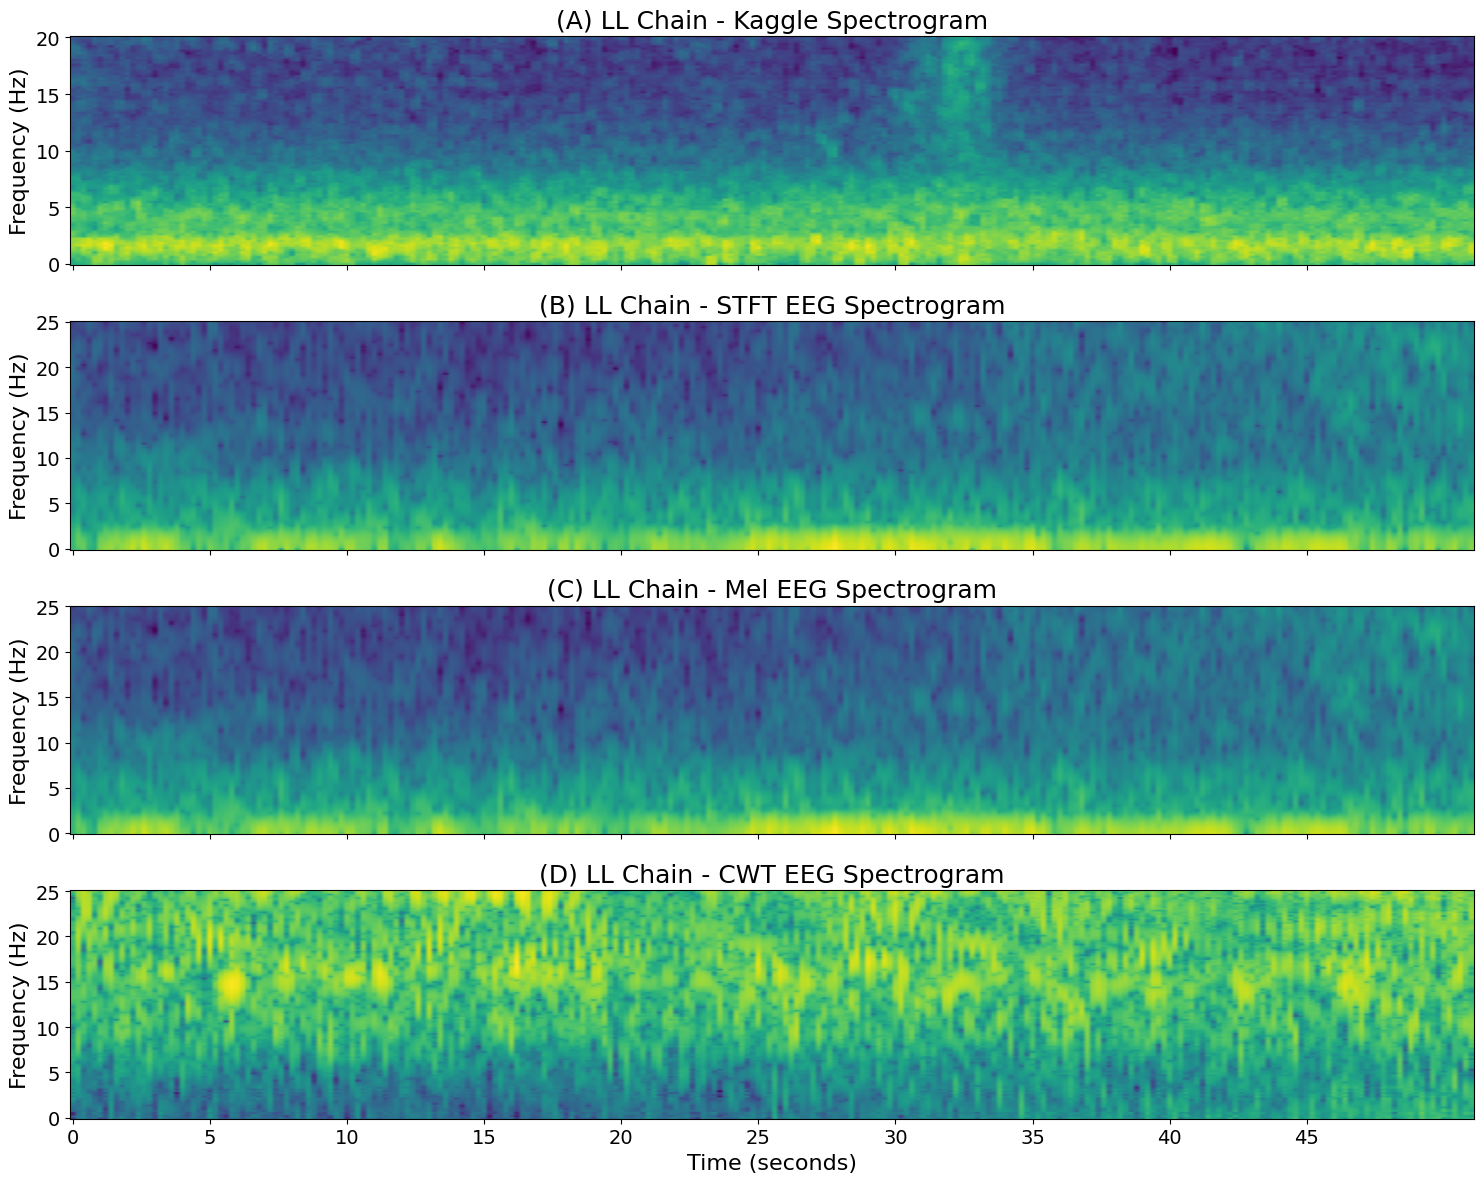

In [34]:
# visualize a single chain of each spectrogram type top to bottom
chain_index = 0  # LL chain
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 12), sharex=True)

# Kaggle Spectrogram
spectrogram_data = kaggle_spectrogram_content.filter(like="LL").to_numpy().T
spectrogram_data = clean_kaggle_spectrogram(spectrogram_data)
axs[0].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
axs[0].set_title("(A) LL Chain - Kaggle Spectrogram")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 5), labels=np.linspace(0, 20, 5).astype(int))

# STFT EEG Spectrogram
spectrogram_data = stft_eeg_spectrogram_parquet[:, :, chain_index]
axs[1].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
axs[1].set_title("(B) LL Chain - STFT EEG Spectrogram")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 6), labels=np.linspace(0, 25, 6).astype(int))

# Mel EEG Spectrogram
spectrogram_data = mel_eeg_spectrogram_parquet[:, :, chain_index]
axs[2].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
axs[2].set_title("(C) LL Chain - Mel EEG Spectrogram")
axs[2].set_ylabel("Frequency (Hz)")
axs[2].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 6), labels=np.linspace(0, 25, 6).astype(int))

# CWT EEG Spectrogram
spectrogram_data = cwt_eeg_spectrogram_parquet[:, :, chain_index]
axs[3].imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
axs[3].set_title("(D) LL Chain - CWT EEG Spectrogram")
axs[3].set_ylabel("Frequency (Hz)")
axs[3].set_yticks(ticks=np.linspace(0, spectrogram_data.shape[0]-1, 6), labels=np.linspace(0, 25, 6).astype(int))

# 256 time steps for 50 seconds
axs[3].set_xticks(ticks=np.arange(0, spectrogram_data.shape[1] - 25, 25), labels=np.arange(0, spectrogram_data.shape[1] * (50 / spectrogram_data.shape[1]), 5).astype(int))
axs[3].set_xlabel("Time (seconds)")
# fig.suptitle(f"Comparison of Spectrograms for LL Chain - EEG ID: {eeg_id}, Spectrogram ID: {spectrogram_id}", fontsize=24, fontweight='bold');
fig.tight_layout()
fig.savefig(f"spectrogram_comparison_eeg_{eeg_id}_spectrogram_{spectrogram_id}.png")